# ISOMIP

This notebook shows how you can do basic analysis of the ISOMIP experiment. This is an example of plot of meridional overturning circulation, barotropic stream function and ice shelf melt pattern. This allow you to compare your results with Losch (2008) and Mathiot et al. (2017).

# Run python script to have figure

To have figure you need 2 outputs:
- output filename
- mesh_mask file (output via namelist parameter nn_msh=1 in "namdom" block)

## Do figure with python script: 

### Import module, define function and load netcdf variables

In [1]:
%pylab inline
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt 
import pylab
import matplotlib as mpl
import matplotlib.colors as colors
import sys
mpl.rcParams['axes.linewidth'] = 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_cmap(cpal, lvl, cext='neither', cbad='w'):
    nintlvl=len(lvl)-1
    if cext=='neither':
        ntotlvl=len(lvl)-1 ; imin=0 ; imax=ntotlvl
    elif cext=='both':
        ntotlvl=len(lvl)+1 ; imin=1 ; imax=ntotlvl-1
    elif cext=='max':
        ntotlvl=len(lvl)   ; imin=0 ; imax=ntotlvl-1
    elif cext=='min':
        ntotlvl=len(lvl)   ; imin=1 ; imax=ntotlvl
    else:
        print 'colorbar extension should be neither, both, max or min'
        sys.exit(42)

    cmap = plt.get_cmap(cpal,ntotlvl)
    cmap = cmap(np.arange(ntotlvl)) ; cunder=cmap[0]; cover=cmap[-1]
    cmap = cmap[imin:imax]
    cmap=colors.LinearSegmentedColormap.from_list("cmap", cmap, nintlvl)
    cmap.set_bad(cbad, 1.0)
    cmap.set_under(cunder)
    cmap.set_over(cover)
    return cmap

In [3]:
# read netcdf
ncid = nc.Dataset('mesh_mask.nc', mode='r')

# load mask
tmask = ncid.variables['tmask'][0,:,:,:]
umask = ncid.variables['umask'][0,:,:,:]
vmask = ncid.variables['vmask'][0,:,:,:]

# load horizontal metrics
e1v = ncid.variables['e1v'][0,:,:]

# load coordinates
latt = ncid.variables['gphit'][0,:,0]
latt2d = ncid.variables['gphit'][0,:,:]
lont2d = ncid.variables['glamt'][0,:,:]

# load depth
depw = ncid.variables['gdepw_1d'][0,:]

In [4]:
# get dimension
nx = len(ncid.dimensions['x'])
ny = len(ncid.dimensions['y'])
nz = len(ncid.dimensions['nav_lev'])

In [5]:
# close mesh mask
ncid.close()

In [6]:
# read netcdf file
ncidT = nc.Dataset('ISOMIP_1m_00010101_00301231_grid_T.nc', mode='r')
ncidV = nc.Dataset('ISOMIP_1m_00010101_00301231_grid_V.nc', mode='r')

In [7]:
# compute moc, bsf and melt
# load meridional velocity
velV=ncidV.variables['vomecrty'][359,:,:,:]

# load e3t and rebuild depth
velV_e3v=ncidV.variables['e3v'][359,:,:,:]

### compute and plot bsf

/opt/scitools/environments/default/2018_05_22-1/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/opt/scitools/environments/default/2018_05_22-1/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


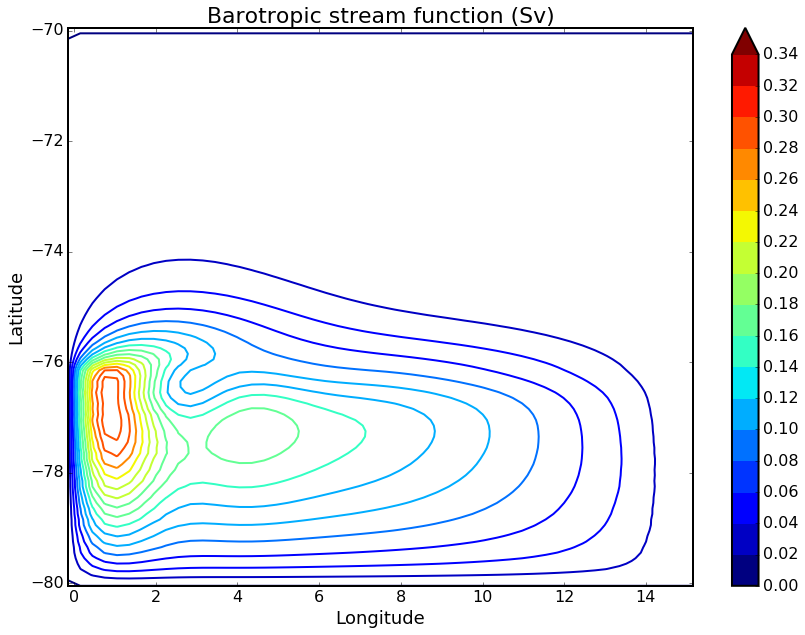

In [8]:
# compute bsf
velV_bsf=np.cumsum(np.sum(velV*velV_e3v,0)*e1v,1)/1.0e6 # in Sv

# plot bsf
fig = plt.figure(figsize=(14, 10)) 

# colorbar bar level definition
eps = 1e-10
lvl = np.arange(0, 0.34+eps, 0.02)
cext = 'max'
cmap = get_cmap('jet', lvl, cext)

# pcolor for colorbar design
pcol = plt.pcolor(lont2d, latt2d, velV_bsf, vmin=lvl[0], vmax=lvl[-1], cmap=cmap)
plt.clf()

# make plot
ax = plt.gca()
ax.contour(lont2d, latt2d, velV_bsf, levels=lvl, linewidths=2, cmap=cmap)
plt.ylim(np.min(latt2d), np.max(latt2d))  
plt.xlim(np.min(lont2d), np.max(lont2d))  

# tidy up the plot (colorbar, axis ...)
cbar= plt.colorbar(pcol, ticks=lvl, extend=cext)
cbar.ax.tick_params(labelsize=16)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Latitude', fontsize=18)
plt.xlabel('Longitude', fontsize=18)
plt.title('Barotropic stream function (Sv)', fontsize=22)

### compute and plot moc

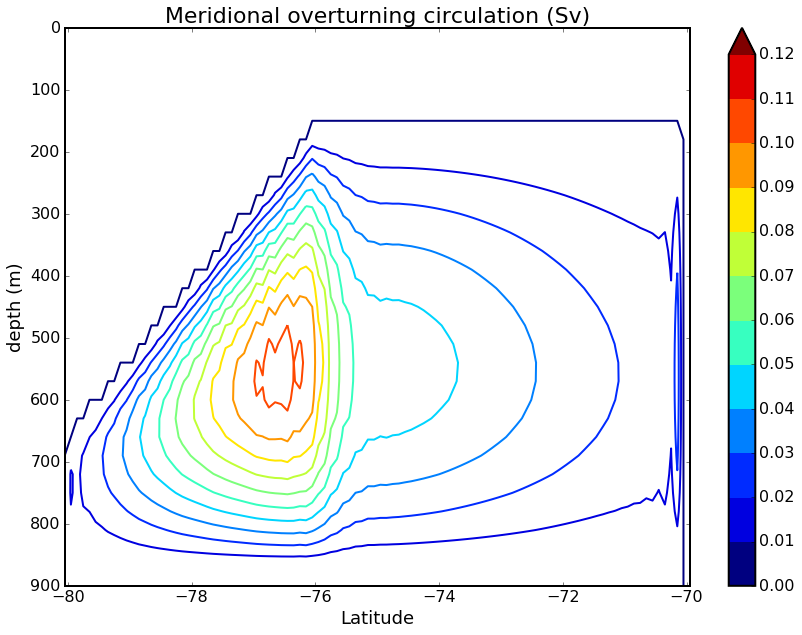

In [9]:
#compute moc
velV_moc = np.zeros(shape=(nz,ny))
velV_moc=np.cumsum(np.sum(velV*velV_e3v*e1v,axis=2),axis=0)/1.0e6

# plot moc
fig = plt.figure(figsize=(14, 10)) 

# colorbar bar level definition
eps = 1e-10
lvl = np.arange(0, 0.12+eps, 0.01)
cext = 'max'
cmap = get_cmap('jet', lvl, cext)

# pcolor for colorbar design
pcol = plt.pcolor(latt, depw, velV_moc, vmin=lvl[0], vmax=lvl[-1], cmap=cmap)
plt.clf()

# make plot
ax = plt.gca()  #get current axis
ax.contour(latt,depw, velV_moc, levels=lvl, linewidths=2, cmap=cmap)
plt.ylim(np.min(depw), np.max(depw))  
plt.xlim(np.min(latt), np.max(latt))  
ax.invert_yaxis() 

# tidy up the plot (colorbar, axis ...)
cbar = plt.colorbar(pcol, ticks=lvl, extend=cext)
cbar.ax.tick_params(labelsize=16)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('depth (m)', fontsize=18)
plt.xlabel('Latitude', fontsize=18)
plt.title('Meridional overturning circulation (Sv)', fontsize=22)

### compute and plot isf melt

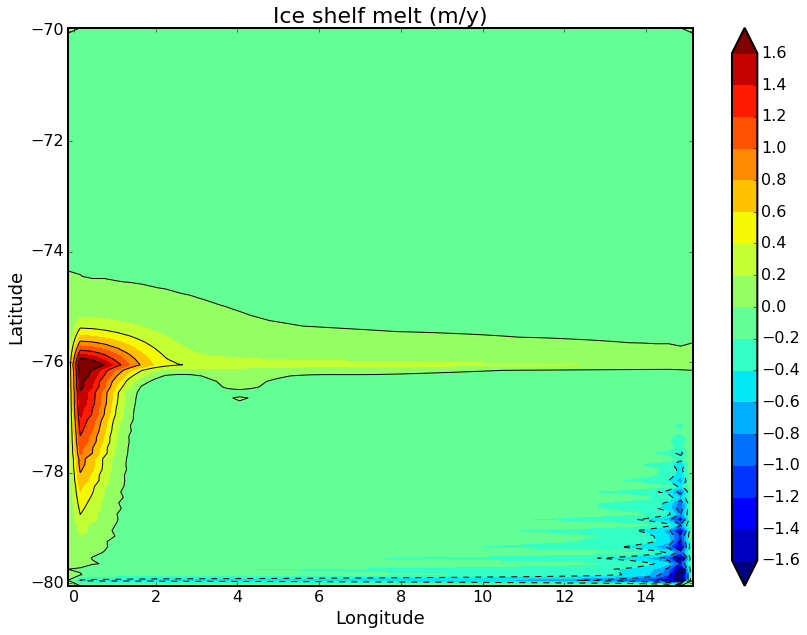

In [10]:
# compute melt
melt = ncidT.variables['sowflisf'][-1,:,:]*86400.0*365.0/1000.0 # in m/y

#plot melt
fig = plt.figure(figsize=(14, 10)) 

# colorbar bar level definition
lvl = np.arange(-1.6, 1.6+eps, 0.2)
cext = 'both'
cmap = get_cmap('jet',lvl,cext)

# pcolor for colorbar design
pcol = plt.contourf(lont2d, latt2d, melt, levels=lvl, cmap=cmap, extend=cext)
plt.contour(lont2d,latt2d,melt,levels=lvl[0::2],colors='k')
plt.ylim(np.min(latt2d), np.max(latt2d))  
plt.xlim(np.min(lont2d), np.max(lont2d))  

# tidy up the plot (colorbar, axis ...)
cbar = plt.colorbar(pcol, ticks=lvl)
cbar.ax.tick_params(labelsize=16)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Latitude', fontsize=18)
plt.xlabel('Longitude', fontsize=18)
plt.title('Ice shelf melt (m/y)', fontsize=22)

In [11]:
# close data file
ncidT.close()
ncidV.close()